# Demo Notebook

This notebook is to demonstrate denoising sampling with our model.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "9"  # Assign GPUs 1 and 2

import warnings
warnings.filterwarnings('ignore')
import torch
import copy
import mediapy
from fillerbuster.utils.visualization_utils import multi_view_batch_to_image, draw_multi_view_batch, get_summary_image_list, draw_cameras
from fillerbuster.utils.random_utils import seed_worker
from fillerbuster.pipelines.nerfstudio_inpaint_pipeline import random_train_pose
from fillerbuster.pipelines.pipeline_functions import get_cameras
import viser
from fillerbuster.data.datasets.dataset_transforms import augment_origins_and_direction
from fillerbuster.utils.camera_path_utils import interpolate_between_cameras, fit_cameras
import time
import numpy as np
from nerfstudio.configs.method_configs import method_configs
from fillerbuster.pipelines.nerfstudio_inpaint_pipeline import InpaintPipelineConfig
import copy
from pathlib import Path
from fillerbuster.data.datasets.nerfstudio_dataset import NerfstudioDataset

seed = 1
local_rank = 0
mixed_precision = True
viser_port = 8890
device = "cuda:0"

if "viser_server" not in globals():
    # only run this once per Python process start
    viser_server = viser.ViserServer(port=viser_port)

print(f"Using GPU name: {torch.cuda.get_device_name(0)}")

╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:8890   │
│   Websocket │ ws://0.0.0.0:8890     │
│             ╵                       │
╰─────────────────────────────────────╯

Using GPU name: NVIDIA RTX A5000


# Load Inpainting Pipeline

In [2]:
data = "/home/ethanweber/fillerbuster/data/lerf-dataset/book_store"
fillerbuster_config = copy.deepcopy(method_configs["splatfacto"])
del fillerbuster_config.pipeline.__dict__["_target"]
nerfstudio_pipeline_config = InpaintPipelineConfig(**fillerbuster_config.pipeline.__dict__)
nerfstudio_pipeline_config.datamanager.data = Path(data) # TODO: maybe give a default here
if "nerfbusters-dataset" in data:
    nerfstudio_pipeline_config.datamanager.dataparser.eval_mode = "filename"
nerfstudio_pipeline = nerfstudio_pipeline_config.setup(device=device)
inpainter = nerfstudio_pipeline.inpainter

[07:22:22] Auto image downscale factor of 1                                                 ]8;id=566101;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=842823;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

            Dataset is overriding orientation method to none                                ]8;id=539230;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=195990;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

Warning: load_3D_points set to true but no point cloud found. splatfacto will use random point cloud initialization.

            Dataset is overriding orientation method to none                                ]8;id=480287;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=500759;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#232\232]8;;\

Loading fillerbuster inpainter...


Text encoder loaded!

Loading the image vae from the checkpoint: /home/ethanweber/fillerbuster/checkpoints/image-vae.ckpt
Loading the image vae weights done.
Loading the pose vae from the checkpoint: /home/ethanweber/fillerbuster/checkpoints/pose-vae.ckpt
Loading the pose vae weights done.
Resuming the training from the checkpoint: /home/ethanweber/fillerbuster/checkpoints/transformer.ckpt
Loading the transformer weights done.
Done loading inpainter.


[07:22:46] Caching / undistorting train images                                            ]8;id=85018;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=768155;file:///home/ethanweber/miniconda3/envs/fillerbuster/lib/python3.10/site-packages/nerfstudio/data/datamanagers/full_images_datamanager.py#230\230]8;;\

Output()

# Load Data

In [3]:
patch_size = 256
num_patches = 10
batch_size = 1
folder = "/home/ethanweber/fillerbuster/data/lerf-dataset/book_store"
eval_stride = -1
percent_force_one_patch_per_image = 1.0
percent_force_fixed_location = 0.0
percent_force_center_crop = 1.0

In [4]:
dataset = NerfstudioDataset(
    local_rank=local_rank,
    global_rank=0,
    world_size=1,
    seed=seed,
    folder=folder,
    shuffle=False,
    num_patches=num_patches,
    strides = (eval_stride,),
    patch_size=patch_size,
    camera_res_scale_factor=0.7 * patch_size / 512,
    use_gpu=False,
    use_ray_augmentation=True,
    percent_force_one_patch_per_image=percent_force_one_patch_per_image,
    percent_force_fixed_location=percent_force_fixed_location,
    percent_force_center_crop=percent_force_center_crop,
    downscale_factor=1,
)
def get_dataloader():
    # wrapping the dataloader in a function to get repeatable sampling
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        worker_init_fn=seed_worker,
        pin_memory=False,
    )
dataloader = get_dataloader()


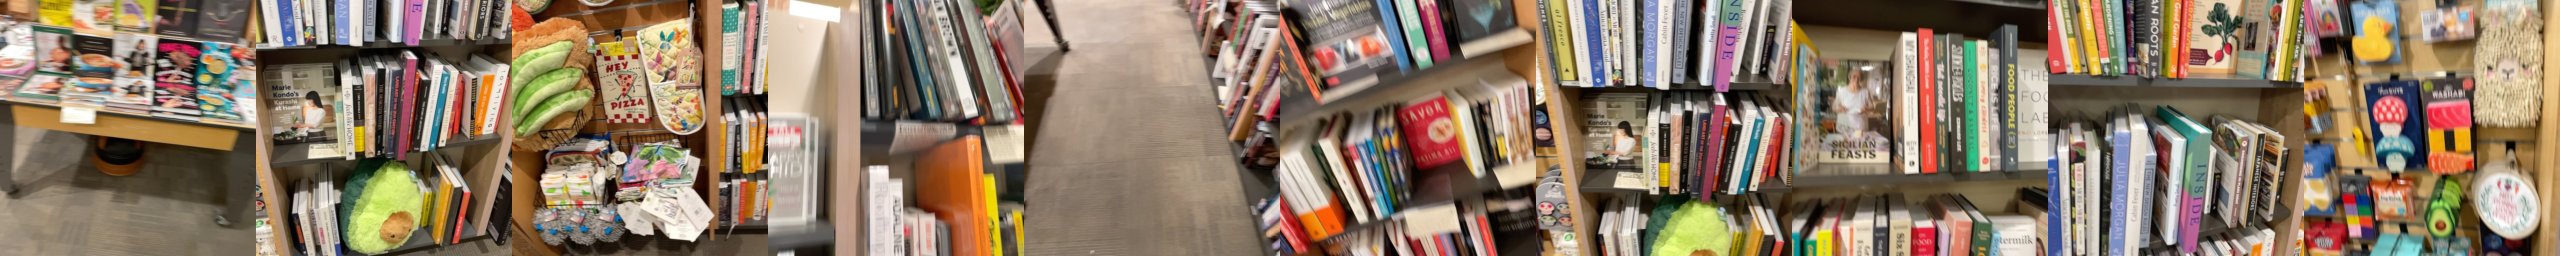

In [5]:
# fetch data and move to GPU
for i, batch in enumerate(dataloader):
    if i == 0:
        break
mediapy.show_image(multi_view_batch_to_image(batch["image"]))

In [6]:
num_test_timesteps = 50
cfg_mv = 5.0
cfg_mv_known = 1.1
cfg_te = 0.0
text = ""
uncond_text = ""
image_strength = 1.0
show_summary = True
show_flattened_video = False # for saving the whole batch as one asset
summary_video_seconds = 8
summary_video_show_top_only = True
summary_image_height = None
summary_video_start_index = 0
rotation_num = 16
concat_start = False
interpolation_steps = 0 # 8
orient_cameras = True
add_circle_views = False
known_image = (0, -1)
known_rays = "all"
multidiffusion_steps = 1

In [7]:
VAE_DOWNSCALE_FACTOR = 8 # TODO: remove this

viser_server.scene.reset()
viser_server.add_box(name="box", color=(255,0,0), dimensions=(2,2,2), position=(0,0,0), visible=False)

image = batch["image"].to(local_rank)  # [b, n, c, h, w]
origins = batch["origins"].to(local_rank)
directions = batch["directions"].to(local_rank)
cameras = get_cameras(batch).to(local_rank)
if concat_start:
    # concat the start to the end
    image = torch.cat([image, image[:,:1]], dim=1)
    origins = torch.cat([origins, origins[:,:1]], dim=1)
    directions = torch.cat([directions, directions[:,:1]], dim=1)
    from nerfstudio.cameras.cameras import Cameras
    cameras = Cameras(
        camera_to_worlds=torch.cat((cameras.camera_to_worlds, cameras.camera_to_worlds[:,:1]), dim=1),
        fx=torch.cat((cameras.fx, cameras.fx[:,:1]), dim=1),
        fy=torch.cat((cameras.fy, cameras.fy[:,:1]), dim=1),
        cx=torch.cat((cameras.cx, cameras.cx[:,:1]), dim=1),
        cy=torch.cat((cameras.cy, cameras.cy[:,:1]), dim=1),
        width=torch.cat((cameras.width, cameras.width[:,:1]), dim=1),
        height=torch.cat((cameras.height, cameras.height[:,:1]), dim=1),
    ).to(image.device)
b, n, c, h, w = image.shape
hd, wd = h // VAE_DOWNSCALE_FACTOR, w // VAE_DOWNSCALE_FACTOR

_ = draw_cameras(viser_server, cameras=cameras[0], datas=[{"image": image[0][i].permute(1,2,0)*255} for i in range(image.shape[1])], prefix="cameras-original", resize=True)

In [8]:
if interpolation_steps > 0:
    image, origins, directions, cameras, image_mask_, rays_mask_ = interpolate_between_cameras(image, cameras, interpolation_steps=interpolation_steps)

# mask is 1 when we have conditioning, 0 otherwise
image_mask = torch.zeros_like(image[:, :, 0:1])
rays_mask = torch.zeros_like(image_mask)
image_mask[:, None if known_image == "all" else known_image] = 1
rays_mask[:, None if known_rays == "all" else known_rays] = 1

if orient_cameras and n > 1:
    poses = torch.cat([cameras.camera_to_worlds, torch.zeros_like(cameras.camera_to_worlds[:,:,:1])], dim=2)
    poses[:,:,-1,-1] = 1
    from nerfstudio.cameras import camera_utils
    poses, transform_matrix = camera_utils.auto_orient_and_center_poses(poses[0].cpu(), method="vertical", center_method="poses")
    scale_factor = 1.0
    scale_factor /= float(torch.max(torch.abs(poses[:, :3, 3])))
    poses[:, :3, 3] *= scale_factor
    cameras.camera_to_worlds = poses[None][:,:,:3,:].to(device)

if add_circle_views:
    fx = cameras.fx[0,0].item()
    fy = cameras.fy[0,0].item()
    radius = 1.0
    circle_images = torch.zeros_like(image[:,:1]).repeat(1, rotation_num, 1, 1, 1)
    circle_cameras = random_train_pose(size=(patch_size,patch_size), device=image.device, radius=radius, rotation_num=rotation_num, vertical_num=1, vertical_min=0, vertical_max=0, fx=fx, fy=fy, inner_radius=radius, lookat_radius=0.0, lookat_height=0.0, jitter_radius=False, jitter_rotation=False, jitter_vertical=False)
    circle_cameras = circle_cameras.reshape((1, circle_cameras.shape[0]))
    _ = draw_cameras(viser_server, cameras=circle_cameras[0], datas=[{"image": circle_images[0][i].permute(1,2,0)*255} for i in range(circle_cameras.shape[1])], prefix="circle-cameras", resize=True)
    
    from fillerbuster.utils.camera_path_utils import get_origins_and_directions_from_cameras
    cameras = Cameras(
        camera_to_worlds=torch.cat((cameras[0].camera_to_worlds, circle_cameras[0].camera_to_worlds)),
        fx=torch.cat((cameras[0].fx, circle_cameras[0].fx)),
        fy=torch.cat((cameras[0].fy, circle_cameras[0].fy)),
        cx=torch.cat((cameras[0].cx, circle_cameras[0].cx)),
        cy=torch.cat((cameras[0].cy, circle_cameras[0].cy)),
        width=torch.cat((cameras[0].width, circle_cameras[0].width)),
        height=torch.cat((cameras[0].height, circle_cameras[0].height)),
    ).to(image.device)
    cameras = cameras.reshape([1] + list(cameras.shape))
    
    image = torch.cat([image, circle_images], dim=1)
    origins, directions = get_origins_and_directions_from_cameras(cameras[0])
    origins = origins[None]
    directions = directions[None]
    image_mask = torch.cat([image_mask, torch.zeros_like(circle_images[:,:,:1])], dim=1)
    rays_mask = torch.ones_like(image_mask)

In [9]:
# plot the known cameras
_ = draw_cameras(viser_server, cameras=cameras[0,known_image], datas=[{"image": image[0][i].permute(1,2,0)*255} for i in known_image], prefix="cameras-known", resize=True, camera_frustum_scale=.1)

Output()

Time to sample (sec): 15.660923480987549



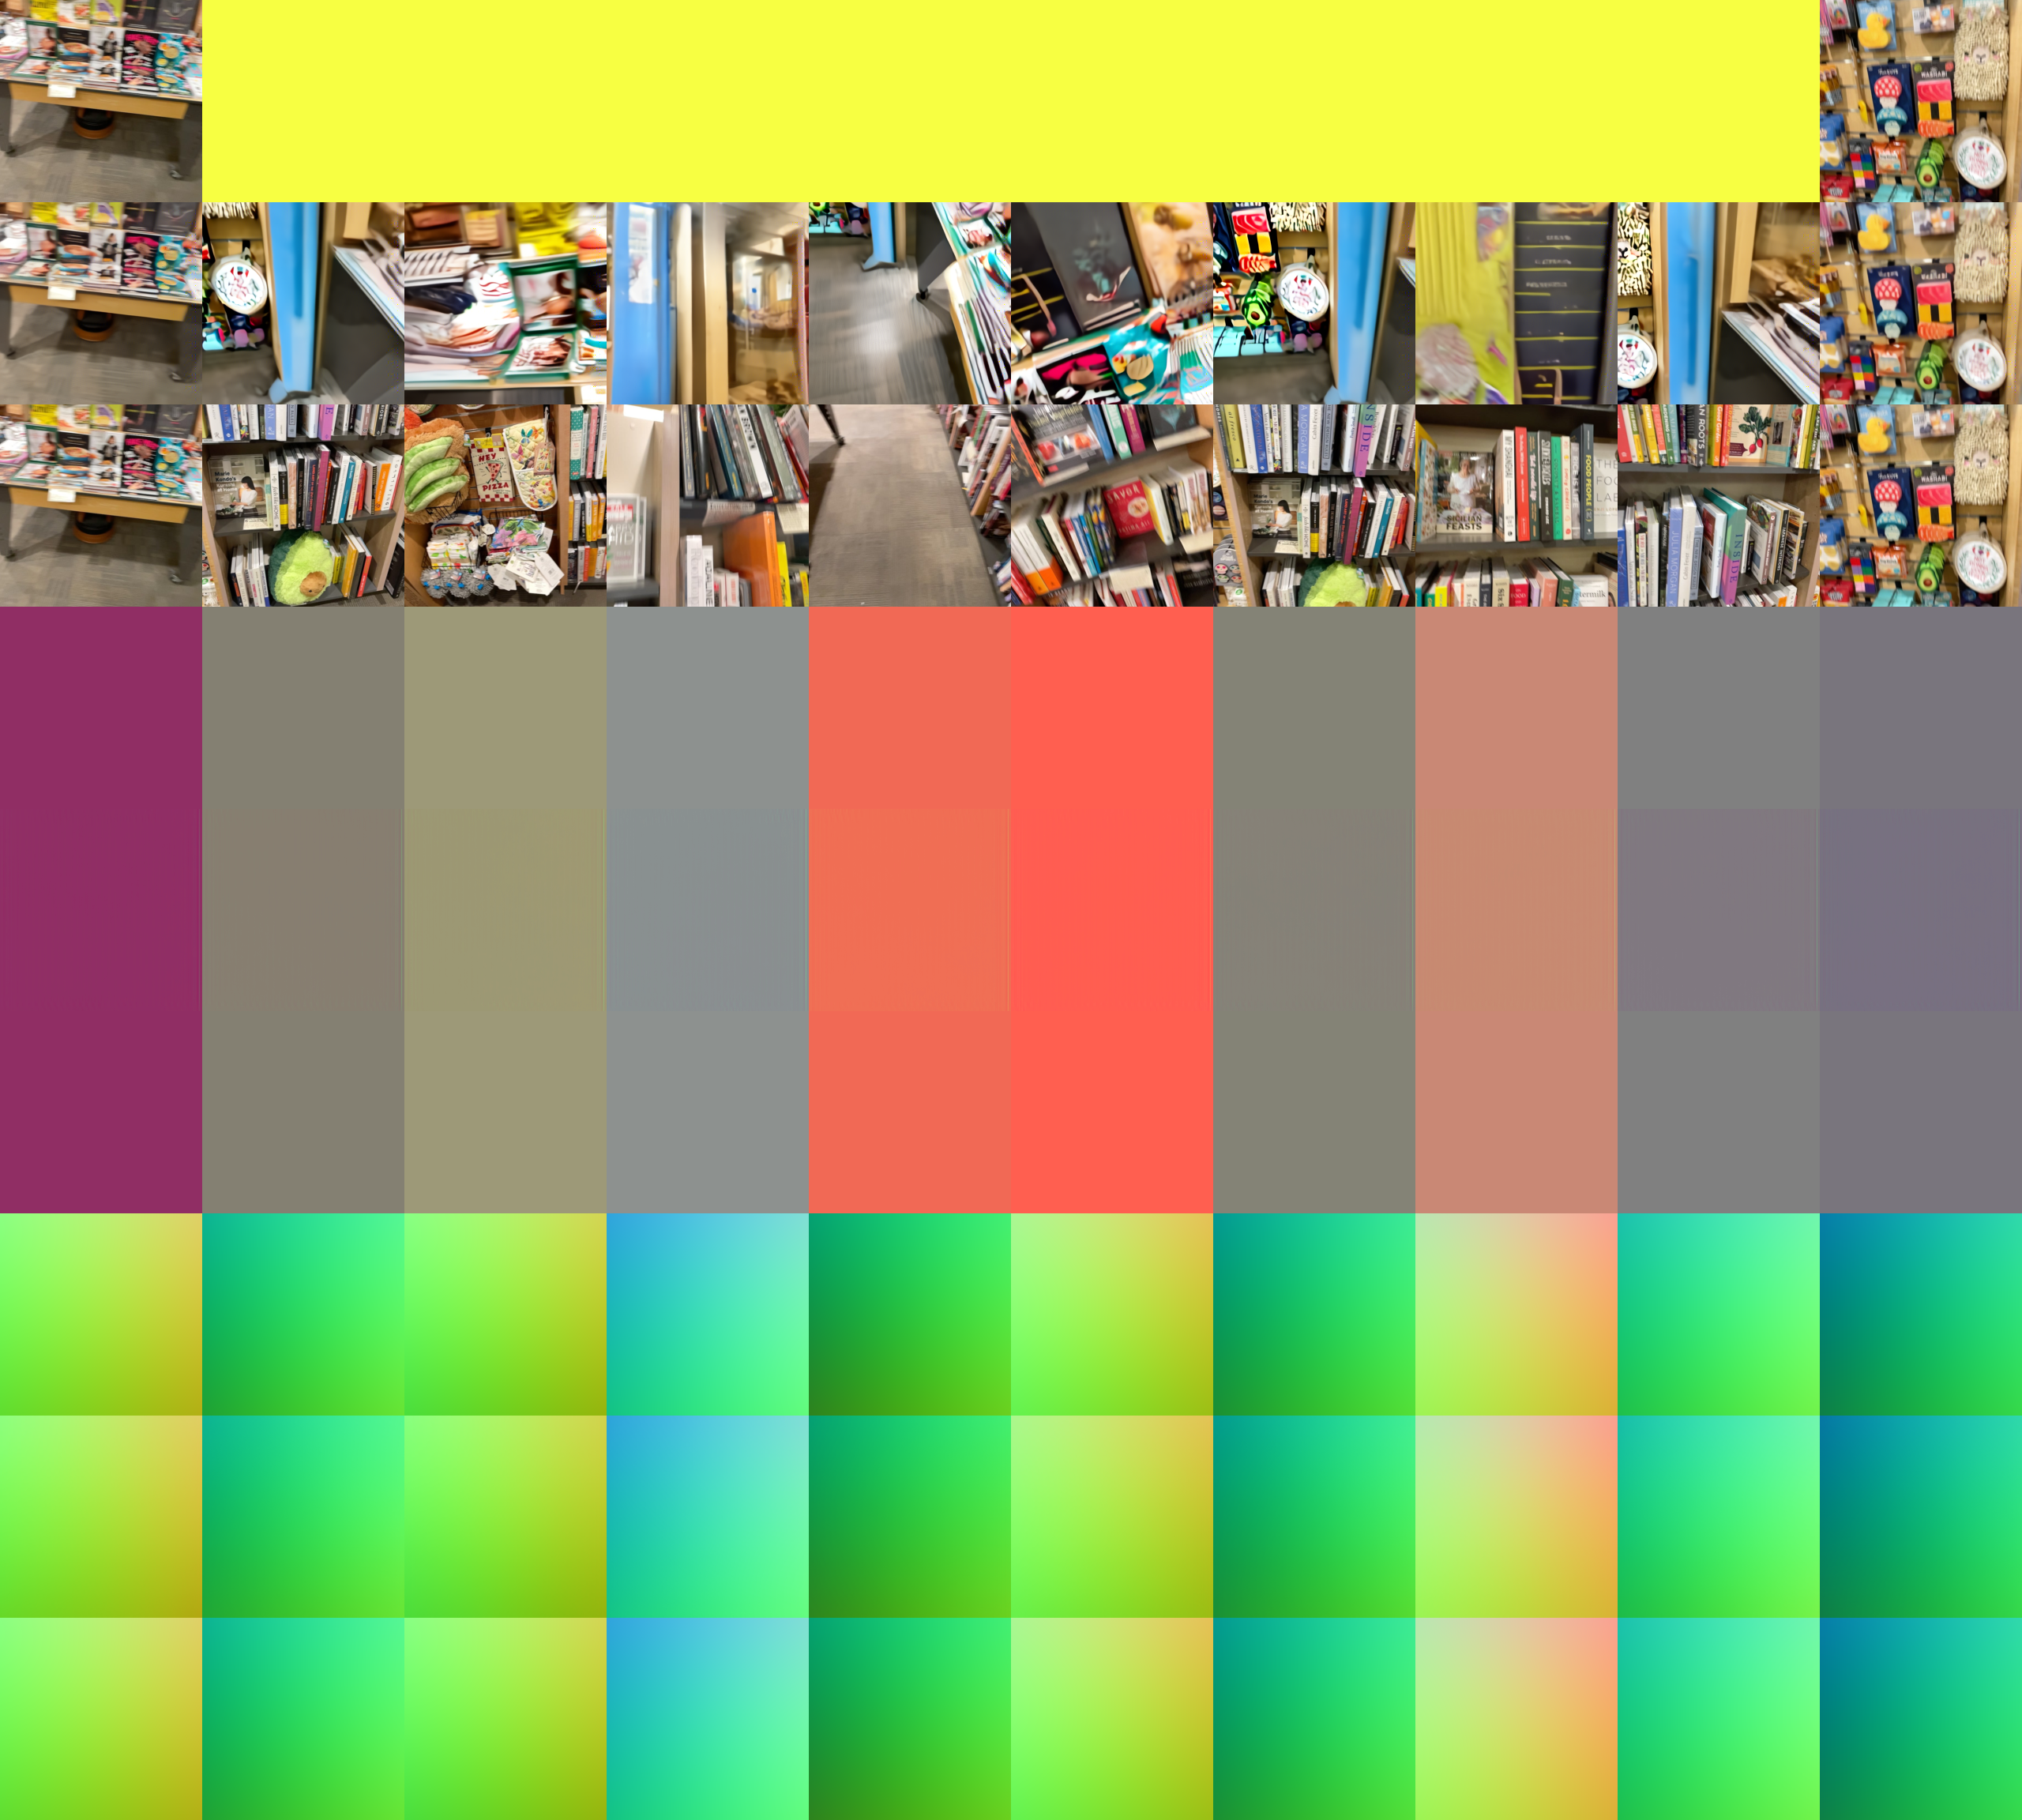

In [10]:
# _ = draw_cameras(viser_server, cameras=cameras[0], datas=[{"image": image[0][i].permute(1,2,0)*255} for i in range(image.shape[1])], prefix="cameras", resize=True)
_ = draw_cameras(viser_server, cameras=cameras[0], datas=None, prefix="cameras", resize=True)

before = time.time()
image_pred, origins_pred, directions_pred = nerfstudio_pipeline.inpainter.inpainter.sample(
    image=image,
    origins=origins,
    directions=directions,
    image_mask=image_mask,
    rays_mask=rays_mask,
    text=text,
    uncond_text=uncond_text,
    current_image=image,
    image_strength=image_strength,
    num_test_timesteps=num_test_timesteps,
    cfg_mv=cfg_mv,
    cfg_mv_known=cfg_mv_known,
    cfg_te=cfg_te,
    camera_to_worlds=cameras.camera_to_worlds,
)
after = time.time()
print(f"Time to sample (sec): {after - before}")

if show_summary:
    # SUMMARY IMAGES
    summary_image_list = get_summary_image_list(image_pred, image,
                                            origins_pred / 2.0 + 0.5, origins / 2.0 + 0.5, directions_pred / 2.0 + 0.5, directions / 2.0 + 0.5,
                                            image_mask, rays_mask)
    mediapy.show_images(summary_image_list, columns=b, height=summary_image_height)
    
    # SUMMARY VIDEOS
    summary_videos = [summary_image.split(w, dim=1) for summary_image in summary_image_list]
    videos = [[frame.numpy()[h:h*2] if summary_video_show_top_only else frame.numpy() for frame in video] for video in summary_videos]
    video_length = len(videos[0][summary_video_start_index:])
    mediapy.show_videos([video[summary_video_start_index:] for video in videos], columns=b, width=w, fps=video_length/summary_video_seconds)
    if show_flattened_video:
        flattened_video = np.concatenate(videos, axis=2)
        mediapy.show_video(flattened_video[summary_video_start_index:], fps=video_length/summary_video_seconds)